In [61]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tslearn.clustering import silhouette_score
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
import itertools

In [62]:
with open('./pickles/allPixelNDVIPoly6.pickle', 'rb') as handle:
    allPixelNDVIPoly3 = pickle.load(handle)

with open('./pickles/newResa6.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('./pickles/kmeans_total_6_c3.pickle', 'rb') as handle:
    kmeans_total3 = pickle.load(handle)

with open('./pickles/kmeans_total_6_c3.pickle', 'rb') as handle:
    kmeans_total3_master = pickle.load(handle)


In [63]:
# Numero di cluster 

num_cluster = 3
XMAx = 15
YMax = 15
allPixelNDVIPoly3 = allPixelNDVIPoly3[(newResa3<=11000) & (newResa3 >= 4000),:]
newResa3 = newResa3[(newResa3<=11000) & (newResa3 >= 4000)]

current_field = 'campo 6'

# Andiamo a calcolare una nuova metrica di coesione

In [64]:
km_one3 = TimeSeriesKMeans(n_clusters=num_cluster, metric="euclidean", max_iter=100,random_state=0)
y_pred_one3 = km_one3.fit_predict(allPixelNDVIPoly3)

(array([ 7.,  6., 11.,  5.,  5.,  8.,  9., 13.,  9., 11.,  8., 16., 14.,
        15., 23., 14., 30., 28., 38., 15., 31., 26., 39., 38., 23., 30.,
        26., 26., 21., 26., 18., 15., 15., 25., 17., 27., 27., 26., 33.,
        41., 27., 53., 37., 39., 40., 30., 52., 39., 28., 47., 36., 34.,
        38., 29., 45., 28., 18., 22., 29., 17., 27., 19., 21., 18., 17.,
        12., 12.,  8.,  8.,  4.,  4.,  7.,  9.,  7.,  2.,  3.,  1.,  1.,
         1.,  2.,  1.,  4.,  2.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([ 4006.  ,  4069.67,  4133.34,  4197.01,  4260.68,  4324.35,
         4388.02,  4451.69,  4515.36,  4579.03,  4642.7 ,  4706.37,
         4770.04,  4833.71,  4897.38,  4961.05,  5024.72,  5088.39,
         5152.06,  5215.73,  5279.4 ,  5343.07,  5406.74,  5470.41,
         5534.08,  5597.75,  5661.42,  5725.09,  5788.76,  5852.43,
         5916.1 ,  5979.77,  6043.44,  6107.11,  6170.78,  6234.45,
         6298.12,  6361.79

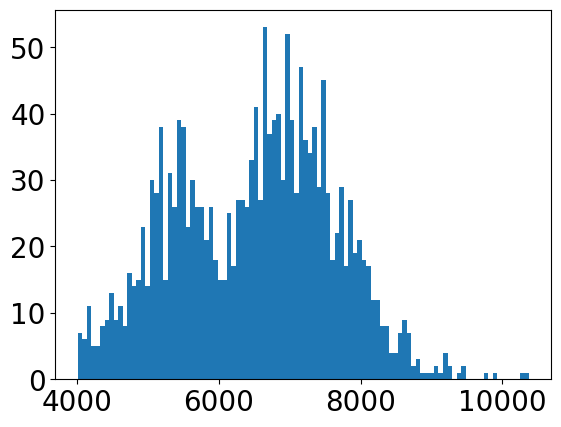

In [65]:
plt.hist(newResa3,100)

In [66]:
label_3 = np.ndarray([newResa3.shape[0]])
label_3_test = np.ndarray([newResa3.shape[0]])

for a,b in zip(newResa3,range(newResa3.shape[0])):
    if(a < np.quantile(newResa3,q=0.25)):
        label_3[b] = int(0) # resa bassa
        label_3_test[b] = int(0) # resa bassa
    elif(a > np.quantile(newResa3,q=0.25) and a < np.quantile(newResa3,q=0.50)):
        label_3[b] = int(1) # resa media
        label_3_test[b] = int(1) # resa media
    
    else:
        label_3[b] = int(3) # resa alta
        label_3_test[b] = int(3) # resa alta

In [67]:
cluster_class_mapping = {}
df = pd.DataFrame(data=[])
for cluster in range(0,num_cluster):
    cluster_classes = label_3[y_pred_one3 == cluster]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    df[cluster] = class_counts
    print('Questo è class count '+ str(class_counts))
    print('Questo è class unique ',unique_classes)
    cluster_class_mapping[cluster] = dominant_class
print(df)

Questo è class count [366 841]
Questo è class unique  [0. 1.]
Questo è class count [483  10]
Questo è class unique  [0. 1.]
Empty DataFrame
Columns: []
Index: []


In [68]:
def best_cluster(matrice):
    a = np.arange(matrice.shape[0])
    permutation = list(itertools.permutations(a))
    obiettivo = {'max': 0,
                'perm':[]}

    for perm in permutation:
        somma = 0
        for elem,index in zip(perm,range(matrice.shape[0])):
            somma += matrice[index,elem]
        if(somma > obiettivo['max']):
            obiettivo['max'] = somma
            obiettivo['perm'] = perm

    test_map = {}
    for pippo,pluto in zip(obiettivo['perm'],range(matrice.shape[0])):
        test_map[pluto] = pippo
    return test_map

                 

In [69]:
# Associazione del cluster i-esimo con la classe i-esima

list_of_mapping = []

for x in range(0,XMAx):

    list_of_mapping.append([])

    for y in range(0,YMax):

        if(kmeans_total3[x,y] is not None):

            cluster_class_mapping = {}
            matrice_elementi = np.ndarray((num_cluster,num_cluster))

            for cluster in range(0,num_cluster):

                cluster_classes = label_3[kmeans_total3[x,y] == cluster]
                unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
                
                if(len(class_counts) < num_cluster):
                    full = np.arange(num_cluster)
                    for a in list(set(full)-set(unique_classes)):
                        class_counts = np.insert(class_counts,values=0,obj=a)
                        
                    matrice_elementi[cluster,:] = class_counts
                else:
                    matrice_elementi[cluster,:] = class_counts


            list_of_mapping[-1].append(best_cluster(matrice_elementi))    
        else:
            continue

In [70]:
for a in range(len(list_of_mapping)):
    for b in range(len(list_of_mapping[a])):
        print(list_of_mapping[a][b])

{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}

In [71]:
list_of_difference = []

for a in range(len(list_of_mapping)):

    list_of_difference.append([])
    for b in range(len(list_of_mapping[a])):

        difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])
        for i in range(num_cluster):
            if(i != list_of_mapping[a][b][i]):

                new_row = pd.Series({'num_cluster': i, 'num_class': list_of_mapping[a][b][i]})
                difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)
        
        list_of_difference[-1].append(difference)

In [72]:
for a in range(len(list_of_difference)):
    for b in range(len(list_of_difference[a])):
        print(list_of_difference[a][b])

  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1         0
  num_cluster num_class
0           0         1
1           1   

In [73]:
for x in range(len(list_of_difference)):
    for y in range(len(list_of_difference[x])):
        indici = []
        if(kmeans_total3[x,y] is not None):
            for a in list_of_difference[x][y]['num_cluster']:
                indici.append([
                index for index in range(len(kmeans_total3[x,y]))
                if kmeans_total3[x,y][index] == a
            ])
            for ind,true_value in zip(indici,list_of_difference[x][y]['num_class']):
                kmeans_total3[x,y][ind] = true_value
        else:
            continue

In [74]:
list_of_mapping_test = []

for x in range(0,int(155/5)):

    list_of_mapping_test.append([])
    for y in range(0,int(155/5)):

        if(kmeans_total3[x,y] is not None):

            cluster_class_mapping = {}
            matrice_elementi = np.ndarray((num_cluster,num_cluster))
            for cluster in range(0,num_cluster):

                cluster_classes = label_3[kmeans_total3[x,y] == cluster]
                unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
                if(len(class_counts) < num_cluster):

                    full = np.arange(num_cluster)
                    for a in list(set(full)-set(unique_classes)):

                        class_counts = np.insert(class_counts,values=0,obj=a)
                    matrice_elementi[cluster,:] = class_counts
                else:
                    matrice_elementi[cluster,:] = class_counts
            list_of_mapping_test[-1].append(best_cluster(matrice_elementi))    
        else:
            continue

In [75]:
for a in range(len(list_of_mapping_test)):
    for b in range(len(list_of_mapping_test[a])):
        print(list_of_mapping_test[a][b])

{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 0, 1: 1}
{0: 1, 1: 0}
{0: 1, 1: 0}
{0: 1, 1: 0}

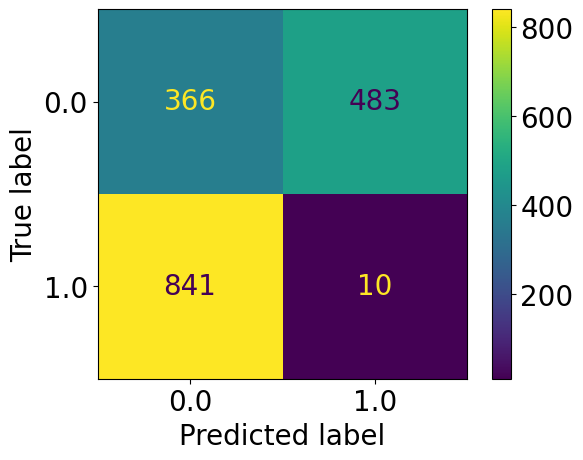

In [76]:
ConfusionMatrixDisplay.from_predictions(label_3,y_pred_one3)
plt.show()

In [77]:
accuracy = str(accuracy_score(label_3,y_pred_one3))
precision = str(precision_score(label_3,y_pred_one3,average= None))
recall = str(recall_score(label_3,y_pred_one3,average= None))

print("accuratezza " + accuracy)
print("precision " + precision)
print("recall " + recall)

accuratezza 0.2211764705882353
precision [0.30323115 0.02028398]
recall [0.43109541 0.01175088]


In [78]:
matrice_precision = np.zeros([XMAx,YMax])
matrice_recall = np.zeros([XMAx,YMax])
matrice_accuracy = np.zeros([XMAx,YMax])

for x in range(0,XMAx):

    for y in range(0,YMax):

        if(kmeans_total3[x,y] is not None):
            matrice_precision[x,y] = precision_score(label_3,kmeans_total3[x,y],average= 'macro')
            matrice_recall[x,y] = recall_score(label_3,kmeans_total3[x,y],average= 'macro')
            matrice_accuracy[x,y] = accuracy_score(label_3,kmeans_total3[x,y])

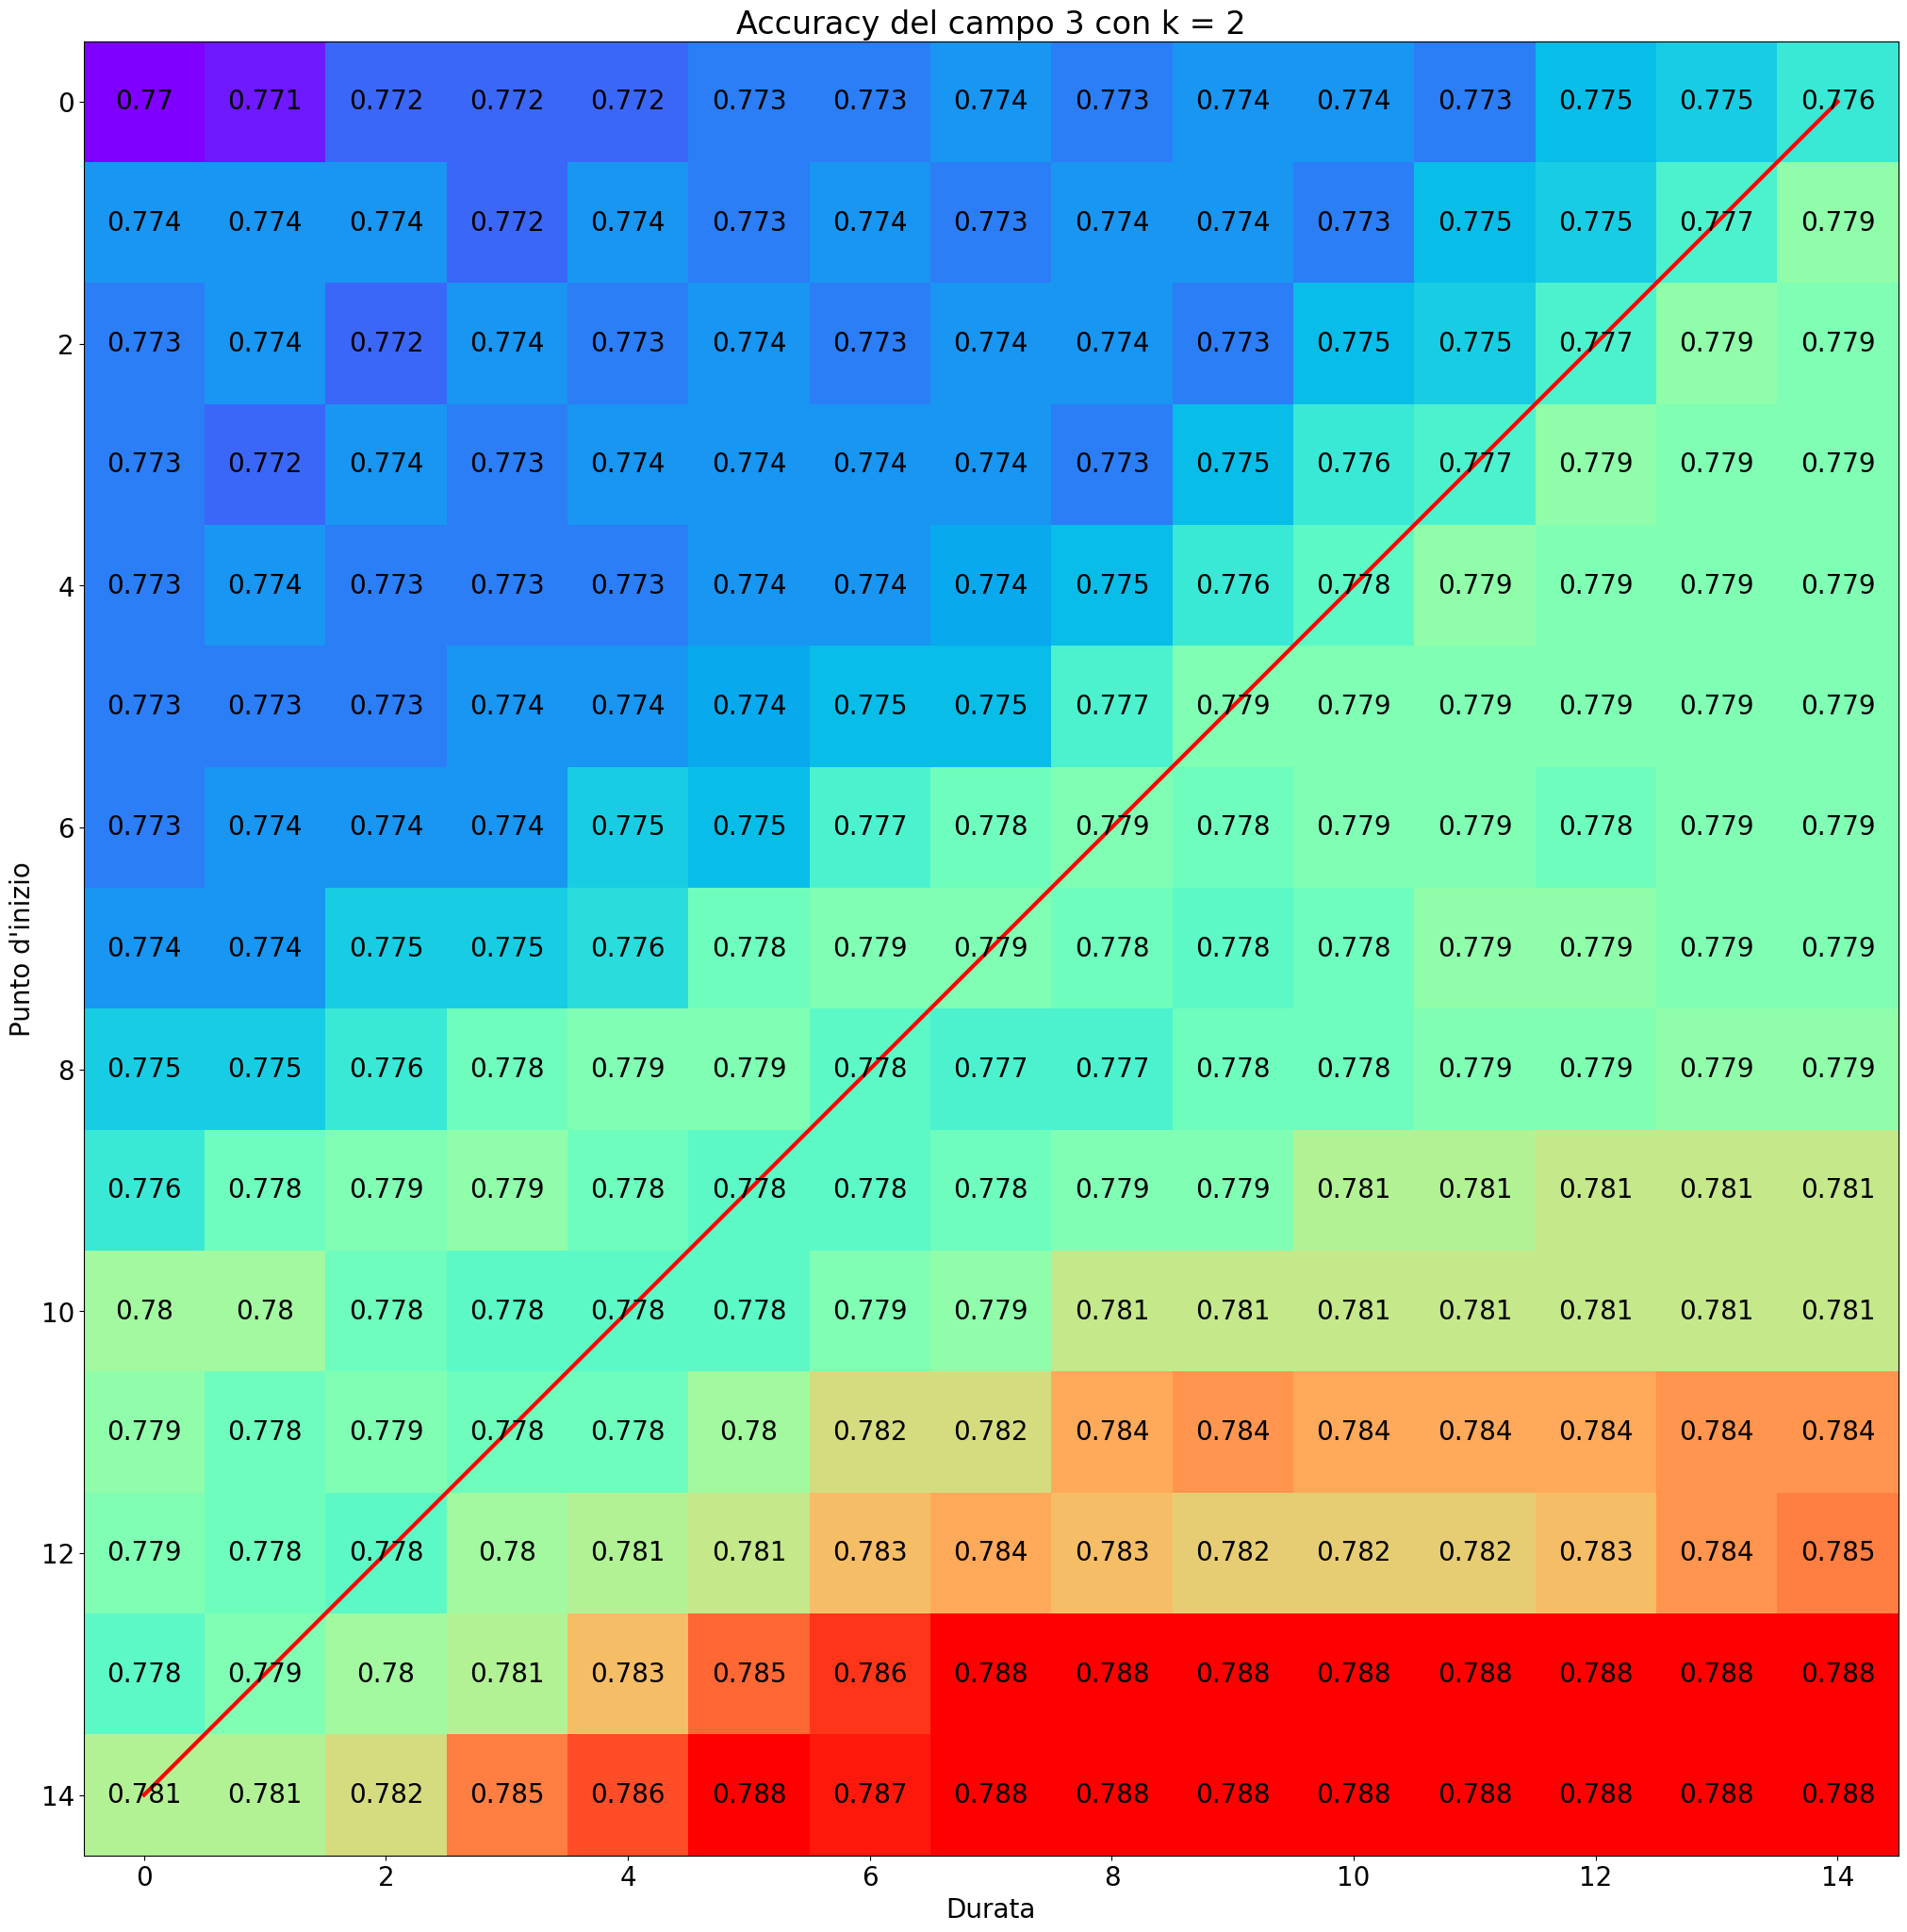

In [79]:
fig, ax = plt.subplots()
plt.rc('font', size=20)
image = ax.imshow(matrice_accuracy[:,:],cmap='rainbow')
line_start = [0, np.floor(71/5)]
line_end = [np.floor(71/5), 0]
plt.plot(line_start, line_end, color="red", linewidth=3)
plt.xlabel("Durata")
plt.ylabel("Punto d'inizio")
plt.title("Accuracy del campo 3 con k = "+str(num_cluster))

fig.set_size_inches(25,25)
for i in range(XMAx):
    for j in range(YMax):
        c = np.round(matrice_accuracy[i,j],decimals=3)
        ax.text(j, i, str(c), va='center', ha='center')
plt.show()
fig.savefig('../image/secondo ricevimento/'+current_field+'/k = '+str(num_cluster)+'/accuracy.png')

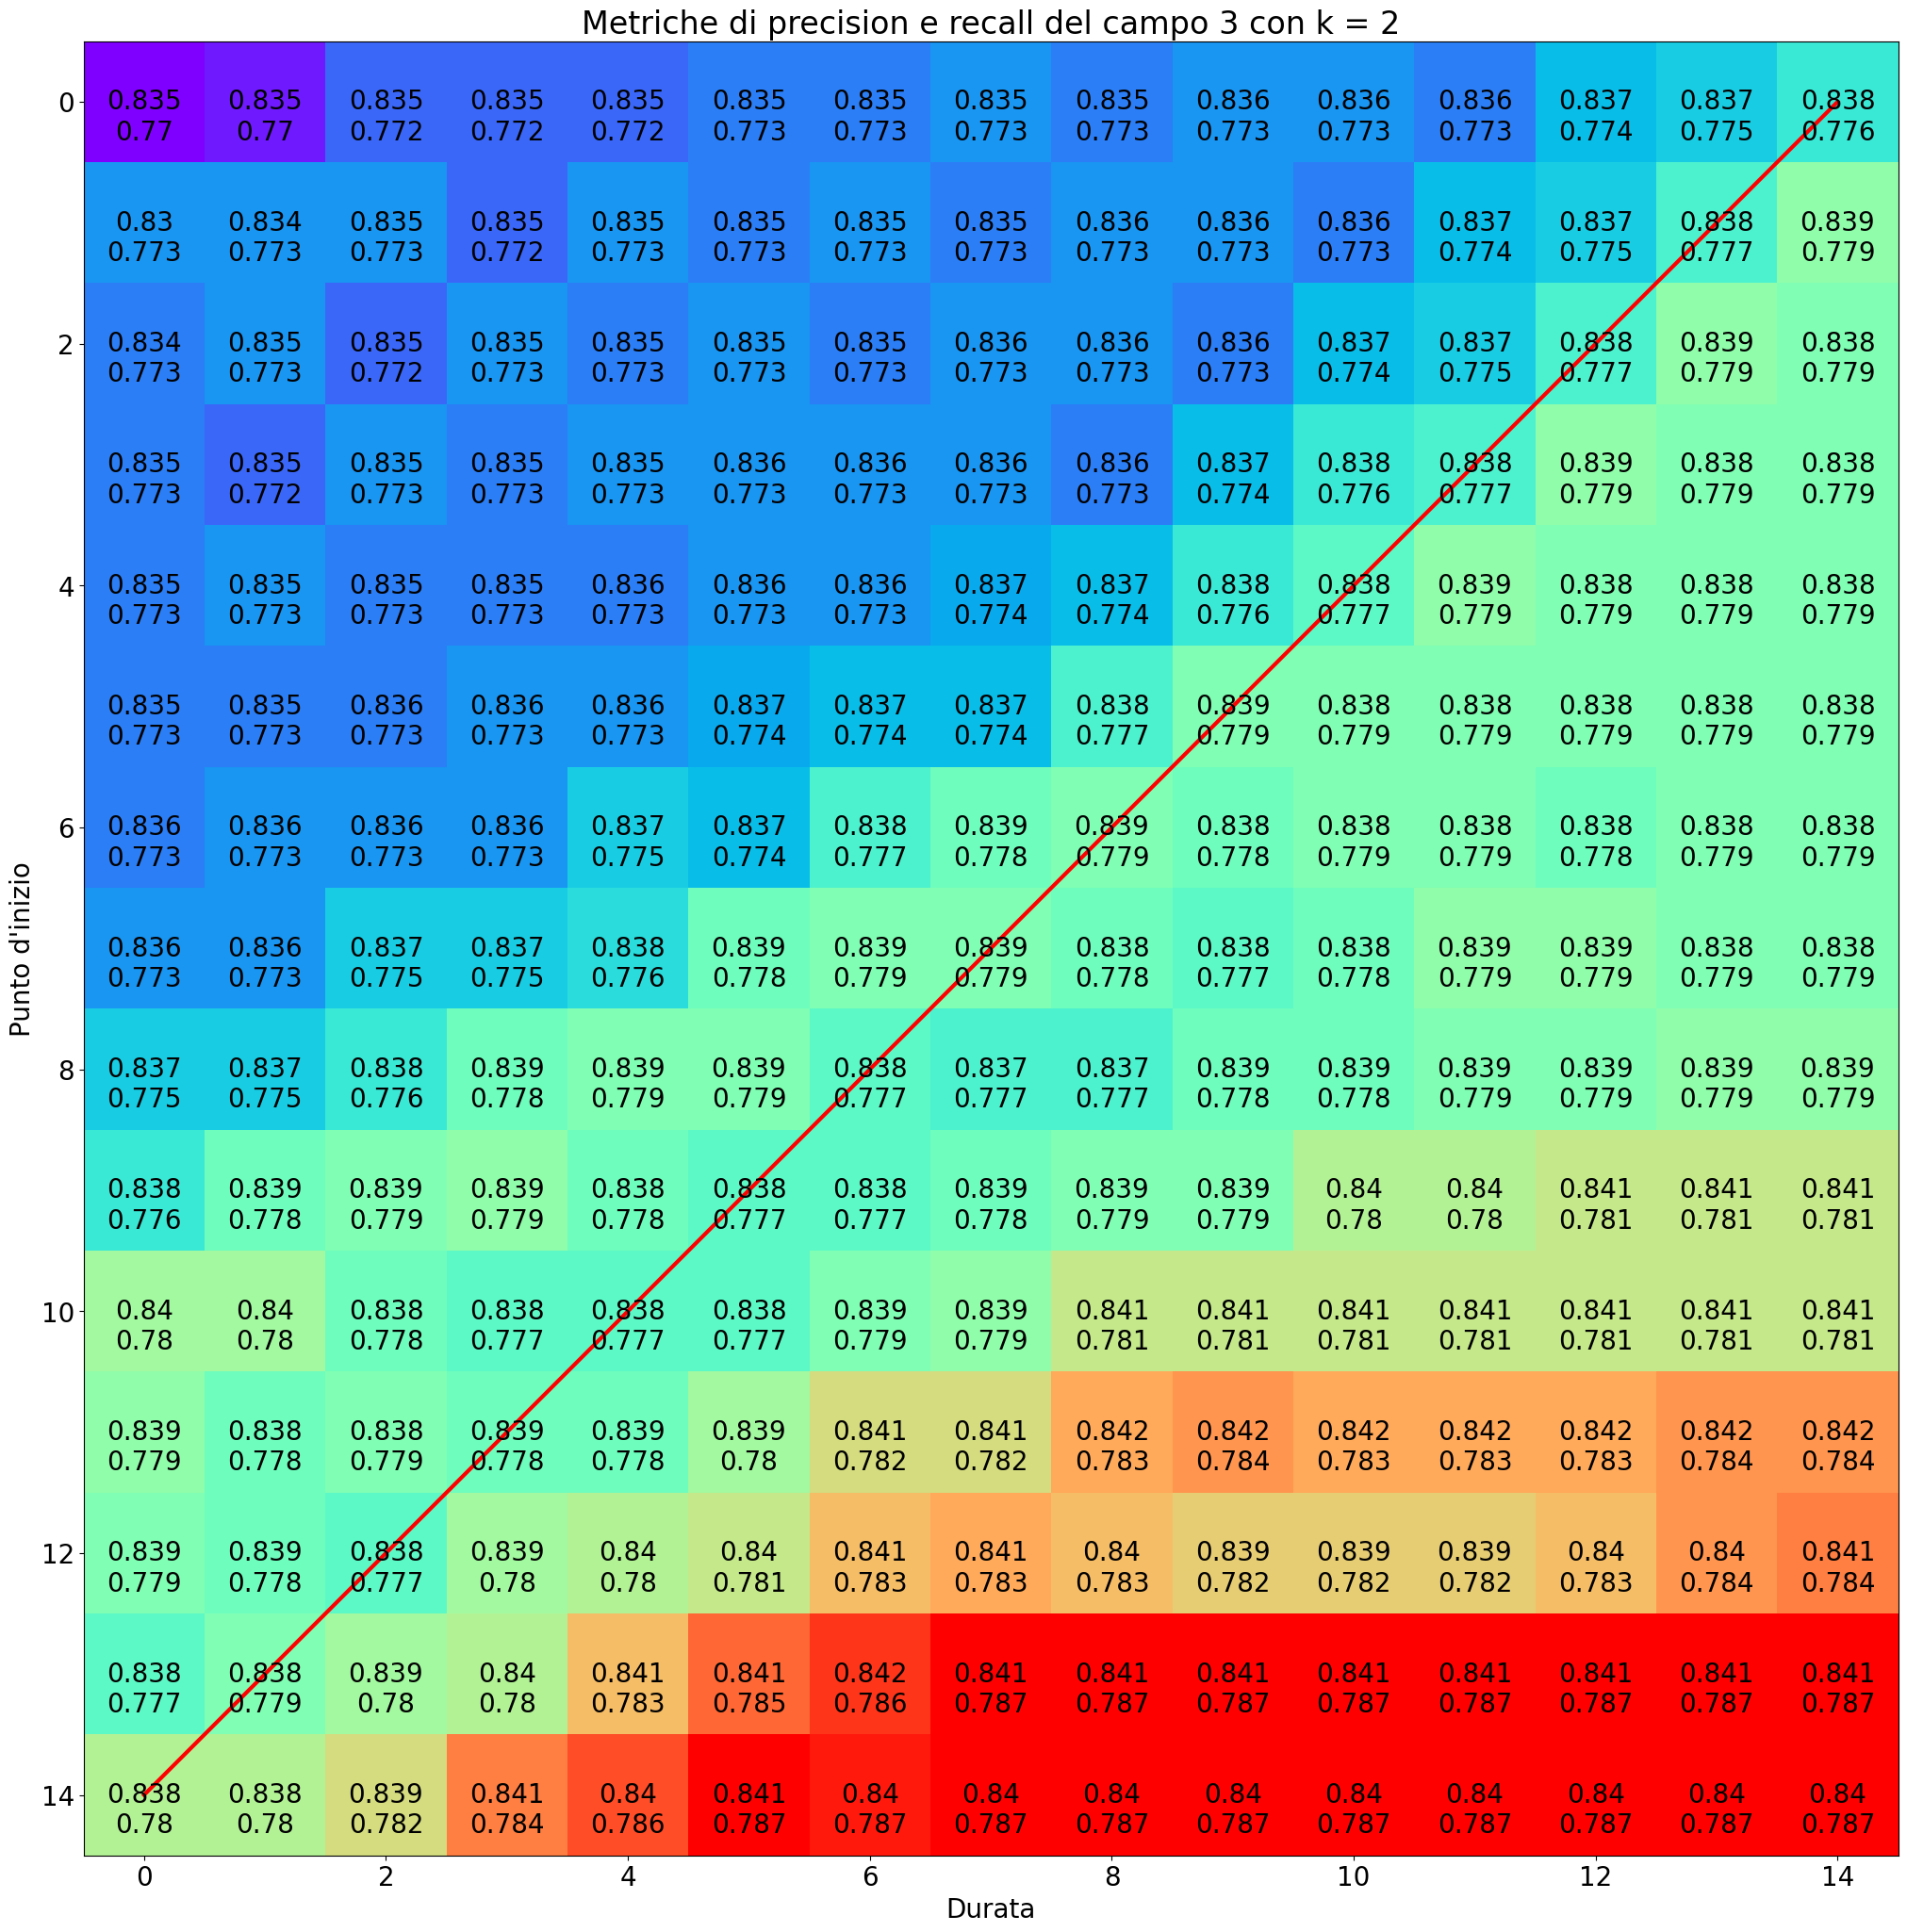

In [80]:
fig, ax = plt.subplots()
image = ax.imshow(matrice_accuracy[:,:],cmap='rainbow')
line_start = [0, np.floor(71/5)]
line_end = [np.floor(71/5), 0]
plt.plot(line_start, line_end, color="red", linewidth=3)
plt.xlabel("Durata")
plt.ylabel("Punto d'inizio")
plt.title('Metriche di precision e recall del campo 3 con k = '+str(num_cluster))

fig.set_size_inches(25,25)
for i in range(XMAx):
    for j in range(YMax):
        c = np.round(matrice_precision[i,j],decimals=3)
        ax.text(j, i, str(c), va='center', ha='center')
        d = np.round(matrice_recall[i,j],decimals=3)
        ax.text(j,(i+0.25),str(d),va='center', ha='center')
plt.show()
fig.savefig('../image/secondo ricevimento/'+current_field+'/k = '+str(num_cluster)+'/pre_rec.png')